## RNNs for Particle Track Classification and Prediction (Toy PANDA Dataset)

In this notebook, we explore the use of **Recurrent Neural Networks (RNNs)** for toy problems inspired by the **Forward Tracking System** of the [PANDA experiment](https://panda.gsi.de), shown below:

![PANDA Forward Tracker](PANDA_full-set-up.png)

We focus on **hit sequences** registered in the forward tracker (red labeled sub-detectors in the figure), which are crucial for reconstructing the trajectories of charged particles in the forward region.

We will explore **two learning tasks**:


###  1. One-to-Many: Hit Classification

Given a **track seed or hit origin**, we aim to classify subsequent hits (tracklets) as:

- ✅ **True** → if they belong to the **same track**
- ❌ **False** → if they come from **different tracks**

This is a **sequence classification** task, where a **single input (seed)** generates a **sequence of binary labels** — one per hit in the tracklet.

###  2. Many-to-Many: Track Prediction

Given a **partial set of hits (seed track)**, predict the **following hit positions** that would complete the true track.  
This is a **sequence-to-sequence** task where:

- Input: initial \( N \) hit positions (seeds)
- Output: predicted next \( M \) hit positions

We will use an RNN or LSTM architecture to capture the **temporal and geometric dependencies** between hits as the track passes through the detector layers.


These are **simplified, toy versions** of the full PANDA reconstruction pipeline but are excellent for understanding how sequential models like RNNs can be applied to particle tracking problems.


###  **1. One-to-Many: Tracklet Classification**

In [ ]:
from panda_utils import load_events

# Read the toy dataset
events = load_events('PANDA_toy_dataset.csv', chamber_id=None, start=0, end=2000)

Stations selected are:  [1 2 3 4 5 6]


### Plot an event

Text(0, 0.5, 'x [cm]')

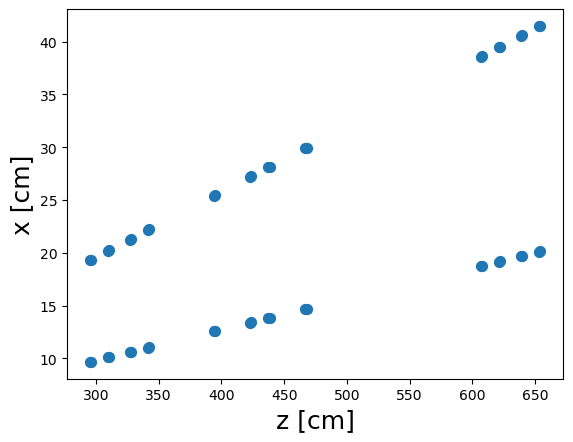

In [7]:
import matplotlib.pyplot as plt
# Select the first event
event = events[0] # This is a pandas dataframe

plt.scatter(event.z, event.x, s=50)
plt.xlabel('z [cm]', fontsize=18)
plt.ylabel('x [cm]', fontsize=18)

In [ ]:
from panda_utils import create_tracklets
# Create training set
X, y = create_tracklets(events)

# Invistigate the shape (batch_size, time_steps, features)
X.shape, y.shape

100%|██████████| 2000/2000 [00:49<00:00, 40.71it/s]


((115934, 24, 3), (115934, 1))

## Classify Forward Tracks

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# ---------------------------------------
# 1. Split the data and move it to device
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.squeeze(), y_test.squeeze()

print(X_train.shape, y_train.shape)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Convert to PyTorch tensors and move to device
x_train_tensor = torch.as_tensor(X_train).float().to(device)
x_test_tensor = torch.as_tensor(X_test).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device).unsqueeze(1)  # Make shape [N, 1]
y_test_tensor = torch.as_tensor(y_test).float().to(device).unsqueeze(1)  # Make shape [N, 1]


# ---------------------------------------
# 2. Define the RNN model
# ---------------------------------------
class GWClassifierRNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=16, num_layers=1):
        super(GWClassifierRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.rnn(x)  # out: [batch, seq_len, hidden]
        out = out[:, -1, :]   # take the last hidden state
        out = self.fc(out)
        return out

model = GWClassifierRNN().to(device)


# ---------------------------------------
# 3. Define loss and optimizer with momentum
# ---------------------------------------
criterion = nn.BCELoss()  # Binary cross-entropy loss

# SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# ---------------------------------------
# 4. Train the model
# ---------------------------------------
epochs = 100
loss_vals = []

for epoch in range(epochs):
    model.train()
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss_vals.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

(92747, 24, 3) (92747,)
Using device: cuda
Epoch  10 | Loss: 0.6619
Epoch  20 | Loss: 0.6129
Epoch  30 | Loss: 0.5844
Epoch  40 | Loss: 0.5683
Epoch  50 | Loss: 0.5595
Epoch  60 | Loss: 0.5545
Epoch  70 | Loss: 0.5510
Epoch  80 | Loss: 0.5478
Epoch  90 | Loss: 0.5447
Epoch 100 | Loss: 0.5405


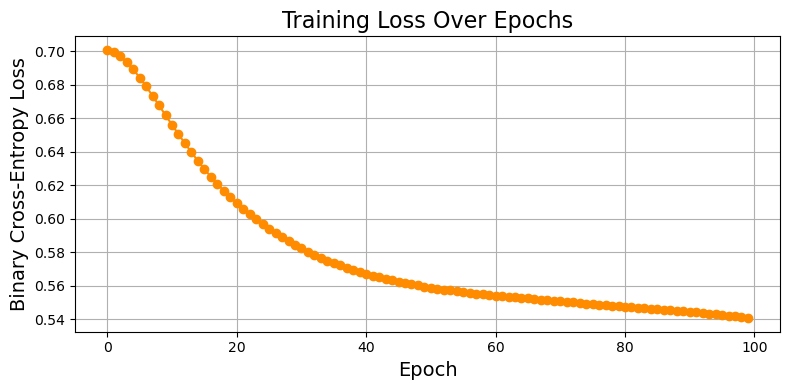

In [13]:
# ---------------------------------------
# 5. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import torchmetrics

acc = torchmetrics.Accuracy(task="binary", num_classes=1)

with torch.no_grad():
    y_hat_test = model(x_test_tensor).cpu()
    print("Accuracy {:.2f}".format(acc(y_hat_test.flatten(), y_test_tensor.cpu().flatten())*100))

Accuracy 75.40


###  **2. Many-to-Many: Track Prediction**

In [ ]:
from panda_utils import create_seeds

# A seed is a track of 4-hits in the first chamber (first layers)
X, y = create_seeds(events)


# Investigate the shape
# TODO: Do you understand what does the shape represents ?
# TODO: Can you plot one of the track seeds ?
# TODO: Can you define and train a sequence model to "predict" the next hit position ?
print (X.shape, y.shape)